# Movie success predictor using SVM (Data Classification)

This code predict the success of the movie by classifying if it is
profitable or not.

* Fatima Falath | 1705727
* Tasneem Annahdi | 1705425
* Thekra ALamoudi | 1705839

**Note:** *this code has 3 parts*
1. Dataset : to fetch the data we will use
2. Data Exploration : To understand the data more
3. Data Classification : to classify the movies(Profitable/Not profitable)

In [ ]:
#import libraries
import pandas as pd
import numpy as np                          
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
#read and view the data
imdb_df = pd.read_csv("movie_dataset.csv", encoding = "ISO-8859-1")

In [ ]:
#Get the date's details
imdb_df["released"] = pd.to_datetime(imdb_df["released"])
imdb_df["release_date_month_str"] = pd.DatetimeIndex(imdb_df["released"]).strftime("%b")

drop the data

In [ ]:
#drop the movies when budget = 0
imdb_df = imdb_df[imdb_df.budget != 0]
#drop the movies that aren't made in USA
imdb_df = imdb_df[imdb_df.country == "USA"]
#drop the country column (we know it is USA)
imdb_df = imdb_df.drop(["country"], axis=1)
#drop the first column (no info needed)
imdb_df.drop(imdb_df.columns[0],axis=1,inplace=True)
#drop the released column (we got all needed info)
imdb_df = imdb_df.drop(["released"], axis=1)

In [ ]:
#check if there is any missing value
print('missing values in the data: \n', imdb_df.isnull().sum())

missing values in the data: 
 index                     0
budget                    0
company                   0
director                  0
genre                     0
gross                     0
name                      0
rating                    0
runtime                   0
score                     0
star                      0
votes                     0
writer                    0
year                      0
director_popularity       0
actor_popularity          0
writer_popularity         0
release_date_month_str    0
dtype: int64


In [ ]:
imdb_df.head(5)
print("The dataset shape:",imdb_df.shape)

The dataset shape: (1921, 18)


## Classification

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix, confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.preprocessing import LabelBinarizer

Label and split the data

In [ ]:
def get_classification_data(movies_df, budget_threshold, profitability_threshold, 
                            profitability_class_threshold, verbose=False):
    
    #get a copy of the movie dataset and calculate profitability (ROI)
    ml_df = movies_df.copy()
    ml_df["profitability"] = (ml_df["gross"] -  ml_df["budget"]) / ml_df["budget"]
    ml_df = ml_df[(ml_df["budget"] > budget_threshold) & \
                  (ml_df["profitability"] < profitability_threshold)]
   

    #Check if the profitability larger than threshold
    #if true return 1 (profitable)
    #if  false return 0 (not profitable)
    ml_df["profitable"] = np.where(ml_df["profitability"] > profitability_class_threshold, 1, 0)
    ml_df_corr = ml_df[["budget", "gross", "profitability"]].corr()
    ml_df_corr = ml_df[["budget", "gross", "profitability"]].corr()
    print(ml_df_corr)

    #drop not needed columns (post-released features)
    drop_cols = ["index","name",  "gross", "profitability", "votes", "score"]
    ml_df.drop(drop_cols, axis="columns", inplace=True)
    ml_df = ml_df.fillna(0)

    #specify the y(target) and x(features) for the data
    y = ml_df["profitable"]
    X = ml_df.drop(["profitable"], axis=1)
    print(X.count())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42, stratify=y)
    #print info
    if verbose:
        print("y.value_counts() :")
        print(y.value_counts())
        print("y.shape :", y.shape)
        print("X.shape :", X.shape)
        print("ml_df.columns :", list(ml_df.columns)[:])
        print("X.columns :", list(X.columns)[:])

    return X_train, X_test, y_train, y_test

In [ ]:
budget_threshold = 10000             
profitability_threshold = 2.0        
profitability_class_threshold = 0.24
X_train, X_test, y_train, y_test = get_classification_data(imdb_df, budget_threshold,
                        profitability_threshold,profitability_class_threshold, True)

                 budget     gross  profitability
budget         1.000000  0.769583       0.023851
gross          0.769583  1.000000       0.468896
profitability  0.023851  0.468896       1.000000
budget                    1676
company                   1676
director                  1676
genre                     1676
rating                    1676
runtime                   1676
star                      1676
writer                    1676
year                      1676
director_popularity       1676
actor_popularity          1676
writer_popularity         1676
release_date_month_str    1676
dtype: int64
y.value_counts() :
0    1098
1     578
Name: profitable, dtype: int64
y.shape : (1676,)
X.shape : (1676, 13)
ml_df.columns : ['budget', 'company', 'director', 'genre', 'rating', 'runtime', 'star', 'writer', 'year', 'director_popularity', 'actor_popularity', 'writer_popularity', 'release_date_month_str', 'profitable']
X.columns : ['budget', 'company', 'director', 'genre', 'rating', 'run

Build the SVM classifier

In [ ]:
def svm_classifier(X_train, X_test, y_train, y_test, numeric_cols, categorical_cols):
      rnd_st = 42
      k_feat = [100]
      no_classifiers = 3
      scoring_metric = "roc_auc"
      
      print("The scoring metric is: ", scoring_metric)
      print("========= SVM =========")

      #Tranform the numerical and categorical columns
      trans = [("num", MinMaxScaler(), numeric_cols), 
               
             ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ]
      col_transform = ColumnTransformer(transformers=trans, remainder="passthrough")

      #Pipeline
      pipeline = Pipeline(steps=[("prep", col_transform), 
                               ("feat", SelectKBest()),
                               ("estimator", SVC())])

      #Specify the estimators (svm)
      est_list = [
                "SVC",
                "SVC",

                "SVC", 
                "SVC",

                "SVC",
                "SVC",
      ]
      #svm with multiple kernels to get the best one
      grid_dict = [     
                {"estimator": [SVC()],
                  "estimator__kernel": ["linear"],
                  "estimator__C": [1, 10, 100], 
                  "estimator__max_iter": [500000],
                  "estimator__probability": [True],
                  "estimator__random_state": [rnd_st],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },    
                 {"estimator": [SVC()],
                  "estimator__C": [0.1, 1.0, 10.0, 100.0], 
                  "estimator__kernel": ["poly"],
                  "estimator__degree": [2, 3, 4, 5],
                  "estimator__gamma": ["scale", "auto"],
                  "estimator__probability": [True],
                  "estimator__max_iter": [500000],
                  "estimator__random_state": [rnd_st],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 {"estimator": [SVC()],
                  "estimator__C": [1, 10, 100], 
                  "estimator__kernel": ["rbf", "sigmoid"],
                  "estimator__gamma": ["scale", "auto"],
                  "estimator__probability": [True],
                  "estimator__max_iter": [500000],
                  "estimator__random_state": [rnd_st],
                  "feat__k": k_feat,
                  "feat__score_func": [f_classif], # [f_classif, mutual_info_classif, chi2]
                 },
                 
      ]

        
      
      grid_dict = grid_dict[:no_classifiers]
    
      idx = 1
      plt.clf()
      fig, axes = plt.subplots(nrows=no_classifiers, ncols=2, 
                              figsize=(12, 12 * no_classifiers / 2.25))


      fitted_classifiers = []

      #Run svm with 3 different filters
      for  grid in grid_dict:

          grid = GridSearchCV(estimator=pipeline, param_grid=grid, scoring=scoring_metric, cv=5) # , n_jobs=2
          grid.fit(X_train, y_train)

          fitted_classifiers.append(grid)
          fitted_classifiers.append(grid)

      for name, grid, ax in zip(est_list, fitted_classifiers, axes.flatten()):
          if idx % 2 != 0:     
              #find the best parameters for each filter  
              best_params = grid.best_params_
              print("********************************{}*********************************".format(name))
              print("best_params :", best_params)

              #predict and calaculate the accuracy
              y_test_pred_proba = grid.predict_proba(X_test)[::,1]
              y_train_pred_proba = grid.predict_proba(X_train)[::,1]
              fpr, tpr, _ = roc_curve(y_test,  y_test_pred_proba)
              y_train_pred = grid.predict(X_train)
              y_test_pred = grid.predict(X_test)
              score_train = grid.score(X_train, y_train)
              score_test = grid.score(X_test, y_test)
              print("score_train :", score_train)
              print("score_test :", score_test)
              accuracy_score_train = accuracy_score(y_train, y_train_pred)
              accuracy_score_test = accuracy_score(y_test, y_test_pred)
              print("accuracy_score_train :", score_train)
              print("accuracy_score_test :", score_test)
              auc_score_train = roc_auc_score(y_train, y_train_pred_proba)
              auc_score_test = roc_auc_score(y_test, y_test_pred_proba)
              print("auc_score_train :", auc_score_train)
              print("auc_score_test :", auc_score_test)
              con_matrix = confusion_matrix(y_test, y_test_pred)
              print("con_matrix :")
              print(con_matrix)
              manual_accuracy = (con_matrix[0][0] + con_matrix[1][1]) / (con_matrix[0][0] + con_matrix[1][1] + con_matrix[0][1] + con_matrix[1][0])
              print("manual_accuracy :", manual_accuracy)

              ax.plot(fpr, tpr, linewidth=3, color="orange", 
                  label="ROC curve (auc={:.2f})".format(auc_score_test))
              ax_min = min([min(y_test_pred), min(y_test)])
              ax_max = max([max(y_test_pred), max(y_test)])
              ax.set_title("{} - ROC Curve".format(name), fontsize=12)
              ax.plot([ax_min, ax_max], [ax_min, ax_max], 
                      linewidth=3, linestyle="--", 
                      color="grey", label="Random guess")
              ax.set_xlim(ax_min, ax_max)
              ax.set_ylim(ax_min, ax_max)
              ax.set_xlabel("False Positive Rate")
              ax.set_ylabel("True Positive Rate")
              ax.legend(loc=4)
          else:    
              plot_confusion_matrix(
                                    grid, 
                                    X_test, y_test, 
                                    ax=ax, 
                                    cmap="Blues", 
                                    values_format="d",
                                    display_labels=["Not profitable", "profitable"]
                                  )
              ax.set_title("{} - Confusion Matrix".format(name), fontsize=12)
              print("***************************************************************************************")

          idx += 1



      plt.tight_layout()
      plt.show()
      return "Run complete"

Run SVM classifier

In [ ]:
#numerical and categorical features in the dataset
numeric_cols=["budget", "runtime", "director_popularity",
                          "actor_popularity", "writer_popularity" ]
categorical_cols=["company", "director","release_date_month_str", "year",
                              "genre", "rating", "star","writer"]


The scoring metric is:  roc_auc
========= SVM =========
********************************SVC*********************************
best_params : {'estimator': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=500000, probability=True, random_state=42, shrinking=True,
    tol=0.001, verbose=False), 'estimator__C': 1, 'estimator__kernel': 'linear', 'estimator__max_iter': 500000, 'estimator__probability': True, 'estimator__random_state': 42, 'feat__k': 100, 'feat__score_func': <function f_classif at 0x7f4c55cea840>}
score_train : 0.7373901724698992
score_test : 0.5927703761755486
accuracy_score_train : 0.7373901724698992
accuracy_score_test : 0.5927703761755486
auc_score_train : 0.7373901724698992
auc_score_test : 0.5927703761755485
con_matrix :
[[209  11]
 [104  12]]
manual_accuracy : 0.6577380952380952
********************************************************************************

<Figure size 432x288 with 0 Axes>

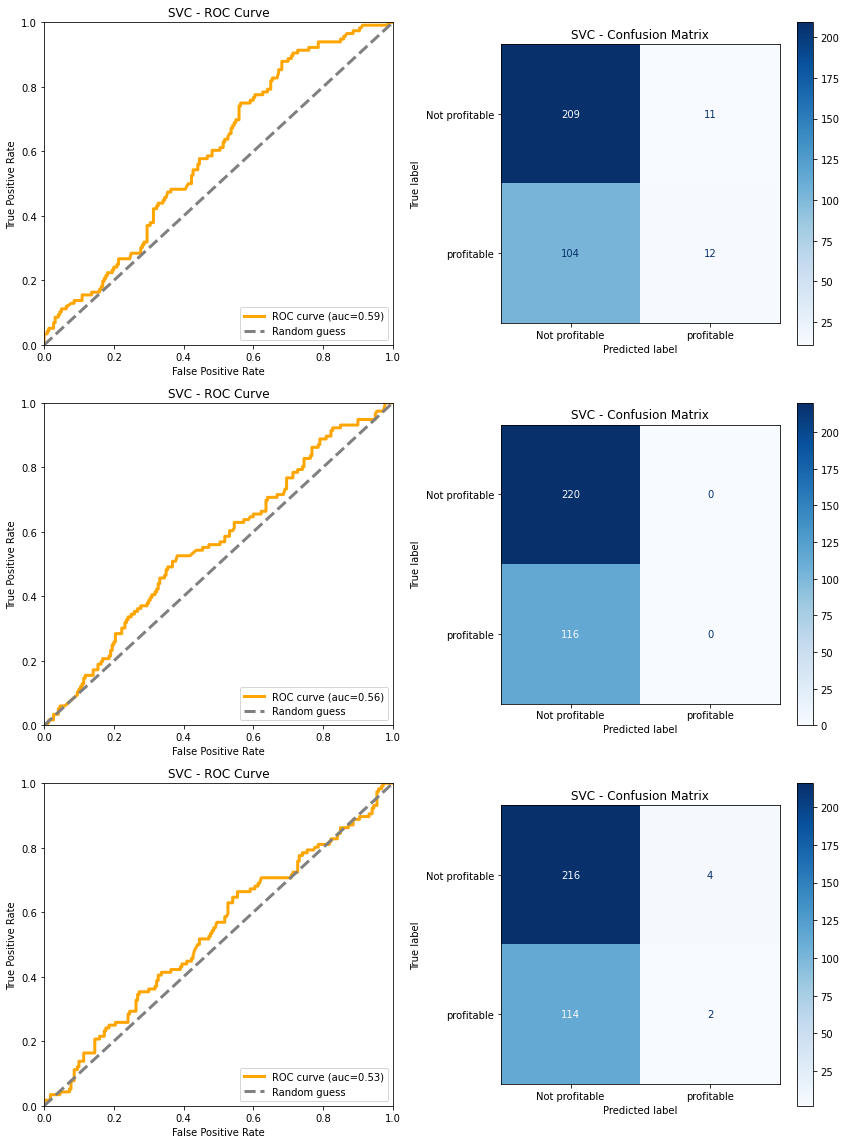

'Run complete'

In [ ]:
#run the SVM classifier
svm_classifier(X_train, X_test, y_train, y_test, numeric_cols, categorical_cols)